# **Crypto forecasting tutorial**

# G-Research Crypto forecasting competition

In the [G-Research Crypto forecasting competition](link), participants have the challenge to predict  price returns across a bundle of major cryptocurrencies. To facilitate your participation, we have created this tutorial notebook covering some relevant concepts for the crypto forecasting challenge.

The notebook presents an introduction to crypto forecasting, describing the structure and elements of the dataset, some relevant statistical properties, as well as building a couple of ML baseline models and providing an example code submission.



## The Cryptocurrency Market

First, a quick introduction to the crypto world. Cryptocurrencies have become an extremely popular and volatile market, delivering massive returns (as well as losses) to investors. Thousands of cryptocurrencies have been created with a few major ones that many of you will have heard of including Bitcoin (BTC), Ether (ETH) or Dogecoin (DOGE).

Cryptocurrencies are traded extensively across crypto-exchanges, with an average volume of $41 billion traded daily over the last year, according to CryptoCompare (as of 25th July 2021). 

Changes in prices between different cryptocurrencies are highly interconnected. For example, Bitcoin has historically been a major driver of price changes across cryptocurrencies but other coins also impact the market.  



## Forecasting returns

A fundamental task in financial modeling is predicting how prices will behave in the near future. Using the time-series of historical prices as training data, we want to predict if prices will go up or down, and by how much, namely the asset *returns*.

In this competition, Kagglers are challenged to build machine learning models to predict the returns of 14 popular cryptocurrencies, in the time scale of minutes to hours. You will have access to millions of rows of minute-by-minute cryptocurrency trading data, with which you'll design your forecasting models for all 14 assets simultaneously. Your predictions will be evaluated by how much they correlate with real market data collected during the three-month evaluation period after the competition has closed. 

Cryptocurrency returns prediction remains an open and extremely challenging forecasting task. This is a fascinating problem domain for the ML community given the extreme volatility of the assets, the non-stationary nature of the data, the market and meme manipulation, the correlation between assets and the very fast changing market conditions. We hope you find it as fascinating as we do! 


# Dataset description

Now, let's dive into the data! We start by loading the competition's dataset and inspecting its basic properties. 

## Load the training set

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime

In [2]:
data_folder = "../input/g-research-crypto-forecasting/"
!ls $data_folder

asset_details.csv	       example_test.csv  supplemental_train.csv
example_sample_submission.csv  gresearch_crypto  train.csv


In [3]:
crypto_df = pd.read_csv(data_folder + 'train.csv')

In [4]:
crypto_df.head(10)

,timestamp,Asset_ID,Count,Open,High,Low,Close,Volume,VWAP,Target
0,1514764860,2,40.0,2376.580000,2399.5000,2357.1400,2374.590000,19.233005,2373.116392,-0.004218
1,1514764860,0,5.0,8.530000,8.5300,8.5300,8.530000,78.380000,8.530000,-0.014399
2,1514764860,1,229.0,13835.194000,14013.8000,13666.1100,13850.176000,31.550062,13827.062093,-0.014643
3,1514764860,5,32.0,7.659600,7.6596,7.6567,7.657600,6626.713370,7.657713,-0.013922
4,1514764860,7,5.0,25.920000,25.9200,25.8740,25.877000,121.087310,25.891363,-0.008264
5,1514764860,6,173.0,738.302500,746.0000,732.5100,738.507500,335.987856,738.839291,-0.004809
6,1514764860,9,167.0,225.330000,227.7800,222.9800,225.206667,411.896642,225.197944,-0.009791
7,1514764860,11,7.0,329.090000,329.8800,329.0900,329.460000,6.635710,329.454118,NaN
8,1514764920,2,53.0,2374.553333,2400.9000,2354.2000,2372.286667,24.050259,2371.434498,-0.004079
9,1514764920,0,7.0,8.530000,8.5300,8.5145,8.514500,71.390000,8.520215,-0.015875


We can see that each row of the data set has the trading data for an asset, at a given minute timestamp, described in detail below. 

## Data features
We can see the different features included in the dataset. Specifically, the features included per asset are the following:
*   **timestamp**: All timestamps are returned as second Unix timestamps (the number of seconds elapsed since 1970-01-01 00:00:00.000 UTC). Timestamps in this dataset are multiple of 60, indicating minute-by-minute data.
*   **Asset_ID**: The asset ID corresponding to one of the crytocurrencies (e.g. `Asset_ID = 1` for Bitcoin). The mapping from `Asset_ID` to crypto asset is contained in `asset_details.csv`.
*   **Count**: Total number of trades in the time interval (last minute).
*   **Open**:	Opening price of the time interval (in USD).
*   **High**:	Highest price reached during time interval (in USD).
*   **Low**: Lowest price reached during time interval (in USD).
*   **Close**:	Closing price of the time interval (in USD).
*   **Volume**:	Quantity of asset bought or sold, displayed in base currency USD.
*   **VWAP**: The average price of the asset over the time interval, weighted by volume. VWAP is an aggregated form of trade data.
*   **Target**: Residual log-returns for the asset over a 15 minute horizon. 

The first two columns define the time and asset indexes for this data row. The 6 middle columns are feature columns with the trading data for this asset and minute in time. The last column is the prediction target, which we will get to later in more detail.

We also view the asset information, including the list of all assets, the `Asset_ID` to asset mapping, and the weight of each asset used to weigh their relative importance in the evaluation metric.

In [5]:
asset_details = pd.read_csv(data_folder + 'asset_details.csv')
asset_details

,Asset_ID,Weight,Asset_Name
0,2,2.397895,Bitcoin Cash
1,0,4.304065,Binance Coin
2,1,6.779922,Bitcoin
3,5,1.386294,EOS.IO
4,7,2.079442,Ethereum Classic
5,6,5.894403,Ethereum
6,9,2.397895,Litecoin
7,11,1.609438,Monero
8,13,1.791759,TRON
9,12,2.079442,Stellar


## Candlestick charts

The trading data format is an aggregated form of market data including for Open, High, Low and Close. We can visualize this data through the commonly used candlestick bar chart, which allows traders to perform technical analysis on intraday values. The bar's body length represents the price range between the open and close of that day's trading. When the bar is red, it means the close was lower than the open, and green otherwise. These are also referred to as bullish and bearish candlesticks. The wicks above and below the bars show the high and low prices of that interval's trading.

We can visualize a slice of the Bitcoin prices using the `plotly` library. The bottom part of the plot shows a rangeslider, which you can use to zoom in the plot.

In [6]:
btc = crypto_df[crypto_df["Asset_ID"]==1].set_index("timestamp") # Asset_ID = 1 for Bitcoin
btc_mini = btc.iloc[-200:] # Select recent data rows

In [7]:
import plotly.graph_objects as go

fig = go.Figure(data=[go.Candlestick(x=btc_mini.index, open=btc_mini['Open'], high=btc_mini['High'], low=btc_mini['Low'], close=btc_mini['Close'])])
fig.show()

# Preprocessing

## Dealing with missing data


Let us inspect the data for another important asset, Ethereum.

In [8]:
eth = crypto_df[crypto_df["Asset_ID"]==6].set_index("timestamp") # Asset_ID = 6 for Ethereum
eth.info(show_counts =True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1956200 entries, 1514764860 to 1632182400
Data columns (total 9 columns):
 #   Column    Non-Null Count    Dtype  
---  ------    --------------    -----  
 0   Asset_ID  1956200 non-null  int64  
 1   Count     1956200 non-null  float64
 2   Open      1956200 non-null  float64
 3   High      1956200 non-null  float64
 4   Low       1956200 non-null  float64
 5   Close     1956200 non-null  float64
 6   Volume    1956200 non-null  float64
 7   VWAP      1956200 non-null  float64
 8   Target    1955860 non-null  float64
dtypes: float64(8), int64(1)
memory usage: 149.2 MB


We can see the number of rows in the training set, and that there are missing values for the targets columns, which we will address later. Let's confirm that:


In [9]:
eth.isna().sum()

Asset_ID      0
Count         0
Open          0
High          0
Low           0
Close         0
Volume        0
VWAP          0
Target      340
dtype: int64

Let's check the time range for Bitcoin and Ethereum data, using the coversion from timestamp to `datetime`.

In [10]:
btc.head()

,Asset_ID,Count,Open,High,Low,Close,Volume,VWAP,Target
timestamp,,,,,,,,,
1514764860,1,229.0,13835.194,14013.8,13666.11,13850.176,31.550062,13827.062093,-0.014643
1514764920,1,235.0,13835.036,14052.3,13680.00,13828.102,31.046432,13840.362591,-0.015037
1514764980,1,528.0,13823.900,14000.4,13601.00,13801.314,55.061820,13806.068014,-0.010309
1514765040,1,435.0,13802.512,13999.0,13576.28,13768.040,38.780529,13783.598101,-0.008999
1514765100,1,742.0,13766.000,13955.9,13554.44,13724.914,108.501637,13735.586842,-0.008079


In [11]:
beg_btc = btc.index[0].astype('datetime64[s]')
end_btc = btc.index[-1].astype('datetime64[s]')
beg_eth = eth.index[0].astype('datetime64[s]')
end_eth = eth.index[-1].astype('datetime64[s]')

print('BTC data goes from ', beg_btc, 'to ', end_btc)
print('Ethereum data goes from ', beg_eth, 'to ', end_eth)

BTC data goes from  2018-01-01T00:01:00 to  2021-09-21T00:00:00
Ethereum data goes from  2018-01-01T00:01:00 to  2021-09-21T00:00:00


Missing asset data, for a given minute, is not represented by NaN's, but instead by the absence of those rows. We can check the timestamp difference between consecutive rows to see if there is missing data.

In [12]:
(eth.index[1:]-eth.index[:-1]).value_counts().head()

60     1956043
120        100
180         23
300          5
540          4
Name: timestamp, dtype: int64

Notice that there are many gaps in the data. To work with most time series models, we should preprocess our data into a format without time gaps. To fill the gaps, we can use the `.reindex()` method for forward filling, filling gaps with the previous valid value. 

In [13]:
eth = eth.reindex(range(eth.index[0],eth.index[-1]+60,60),method='pad')

And check that are no time gaps now.

In [14]:
(eth.index[1:]-eth.index[:-1]).value_counts().head()

60    1956959
Name: timestamp, dtype: int64

## Data visualisation

We  will start by visualising the Close prices for the two assets we have selected.

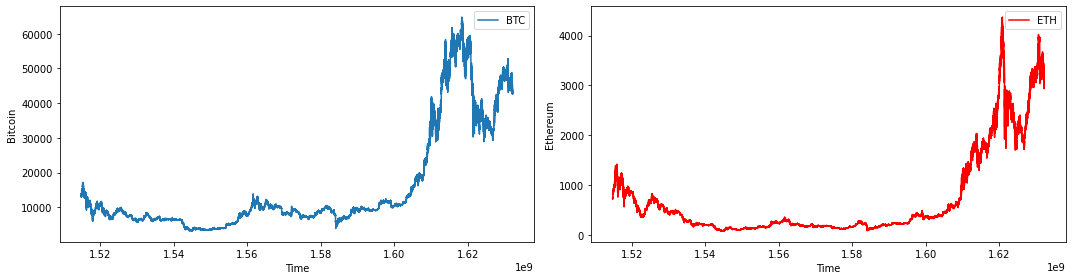

In [15]:
import matplotlib.pyplot as plt

# plot vwap time series for both chosen assets
f = plt.figure(figsize=(15,4))

# fill missing values for BTC
btc = btc.reindex(range(btc.index[0],btc.index[-1]+60,60),method='pad')

ax = f.add_subplot(121)
plt.plot(btc['Close'], label='BTC')
plt.legend()
plt.xlabel('Time')
plt.ylabel('Bitcoin')

ax2 = f.add_subplot(122)
ax2.plot(eth['Close'], color='red', label='ETH')
plt.legend()
plt.xlabel('Time')
plt.ylabel('Ethereum')

plt.tight_layout()
plt.show()

The assets have quite different history, but we could check if they correlate in recent times.

In [16]:
import time

# auxiliary function, from datetime to timestamp
totimestamp = lambda s: np.int32(time.mktime(datetime.strptime(s, "%d/%m/%Y").timetuple()))

# create intervals
btc_mini_2021 = btc.loc[totimestamp('01/06/2021'):totimestamp('01/07/2021')]
eth_mini_2021 = eth.loc[totimestamp('01/06/2021'):totimestamp('01/07/2021')]

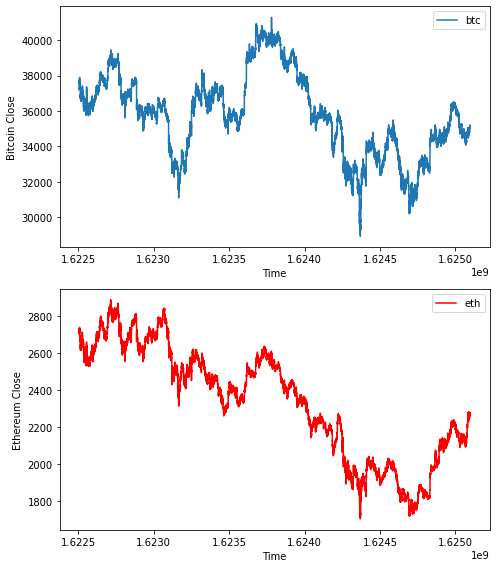

In [17]:
# plot time series for both chosen assets
f = plt.figure(figsize=(7,8))

ax = f.add_subplot(211)
plt.plot(btc_mini_2021['Close'], label='btc')
plt.legend()
plt.xlabel('Time')
plt.ylabel('Bitcoin Close')

ax2 = f.add_subplot(212)
ax2.plot(eth_mini_2021['Close'], color='red', label='eth')
plt.legend()
plt.xlabel('Time')
plt.ylabel('Ethereum Close')

plt.tight_layout()
plt.show()

On shorter intervals we can visually see some potential correlation between both assets, with some simultaneous ups and downs. A better format for analyzing such movements is by calculating asset returns. 

## Log returns

In order to analyze price changes for an asset we can deal with the price difference. However, different assets exhibit different price scales, so that the their returns are not readily comparable. We can solve this problem by computing the percentage change in price instead, also known as the return. This return coincides with the percentage change in our invested capital.

Returns are widely used in finance, however log returns are preferred for mathematical modelling of time series, as they are additive across time. Also, while regular returns cannot go below -100%, log returns are not bounded.

To compute the log return, we can simply take the logarithm of the ratio between two consecutive prices. The first row will have an empty return as the previous value is unknown, therefore the empty return data point will be dropped.

In [18]:
# define function to compute log returns
def log_return(series, periods=1):
    return np.log(series).diff(periods=periods)

We can visualize the log return for our two assets. See how the signal now looks more like white noise, with less drift than the time series for prices.

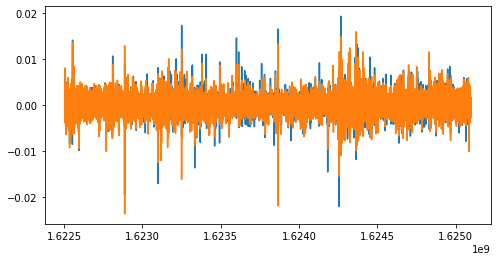

In [19]:
import scipy.stats as stats

lret_btc = log_return(btc_mini_2021.Close)[1:]
lret_eth = log_return(eth_mini_2021.Close)[1:]
lret_btc.rename('lret_btc', inplace=True)
lret_eth.rename('lret_eth', inplace=True)

plt.figure(figsize=(8,4))
plt.plot(lret_btc);
plt.plot(lret_eth);
plt.show()

## Correlation between assets

We hypothesized before that crypto asset returns may exhibit some correlation. Let's check this in more detail now.

We can check how the correlation between Bitcoin and Ethereum change over time for the 2021 period we selected. 

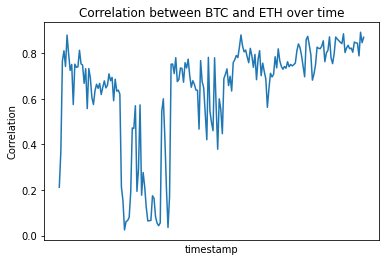

In [20]:
# join two asset in single DataFrame

lret_btc_long = log_return(btc.Close)[1:]
lret_eth_long = log_return(eth.Close)[1:]
lret_btc_long.rename('lret_btc', inplace=True)
lret_eth_long.rename('lret_eth', inplace=True)
two_assets = pd.concat([lret_btc_long, lret_eth_long], axis=1)

# group consecutive rows and use .corr() for correlation between columns
corr_time = two_assets.groupby(two_assets.index//(10000*60)).corr().loc[:,"lret_btc"].loc[:,"lret_eth"]

corr_time.plot();
plt.xticks([])
plt.ylabel("Correlation")
plt.title("Correlation between BTC and ETH over time");

Note the high but variable correlation between the assets. Here we can see that there is some changing dynamics over time, and this would be critical for this time series challenge, that is, how to perform forecasts in a highly non-stationary environment.

A stationary behaviour of a system or a process is characterized by non-changing statistical properties over time such as the mean, variance and autocorrelation. On the other hand, a non-stationary behaviour is characterized by a continuous change of statistical properties over time. Stationarity is important because many useful analytical tools and statistical tests and models rely on it.

We can also check the correlation between all assets visualizing the correlation matrix. Note how some assets have much higher pairwise correlation than others.

In [21]:
# create dataframe with returns for all assets
all_assets_2021 = pd.DataFrame([])
for asset_id, asset_name in zip(asset_details.Asset_ID, asset_details.Asset_Name):
  asset = crypto_df[crypto_df["Asset_ID"]==asset_id].set_index("timestamp")
  asset = asset.loc[totimestamp('01/01/2021'):totimestamp('01/05/2021')]
  asset = asset.reindex(range(asset.index[0],asset.index[-1]+60,60),method='pad')
  lret = log_return(asset.Close.fillna(0))[1:]
  all_assets_2021 = all_assets_2021.join(lret, rsuffix=asset_name, how="outer")

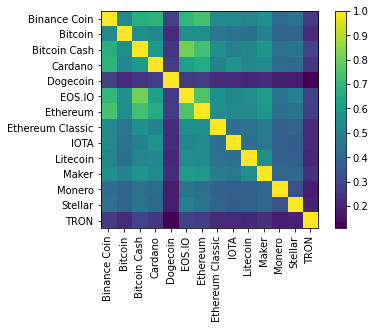

In [22]:
plt.imshow(all_assets_2021.corr());
plt.yticks(asset_details.Asset_ID.values, asset_details.Asset_Name.values);
plt.xticks(asset_details.Asset_ID.values, asset_details.Asset_Name.values, rotation='vertical');
plt.colorbar();

We encourage participants to perform additional statistical analyses to have a stronger grasp on the dataset, including autocorrelation, time-series decomposition and stationarity tests.

# Building your prediction model

## Prediction targets and evaluation

This forecasting competition aims to predict returns in the near future for prices $P^a$, for each asset $a$. For each row in the dataset, we include the target for prediction, `Target`. `Target` is derived from log returns ($R^a$) over 15 minutes.

$$R^a(t) = log (P^a(t+16)\ /\ P^a(t+1))$$

Crypto asset returns are highly correlated, following to a large extend the overall crypto market. As we want to test your ability to predict returns for individual assets, we perform a linear residualization, removing the market signal from individual asset returns when creating the target. In more detail, if $M(t)$ is the weighted average market returns, the target is:

$$M(t) = \frac{\sum_a w^a R^a(t)}{\sum_a w^a}  \\
\beta^a = \frac{\langle M \cdot R^a \rangle}{\langle M^2 \rangle} \\
\text{Target}^a(t) = R^a(t) - \beta^a M(t)$$

where the bracket $\langle .\rangle$ represent the rolling average over time (3750 minute windows), and same asset weights $w^a$ used for the evaluation metric.

Some rows have null values for targets due to missing values in future prices. Rows with nulls in the test set ground truth are ignored for scoring purposes.

In the competition, your predictions will be evaluated on a weighted version of the Pearson correlation coefficient, with weights given by the `Weight` column in the Asset Details file.

In this tutorial, we will simplify things and use correlation (without weights) for evaluation, and consider only two assets, BTC and ETH.

## Feature design

We first design a few relevant features to input to our model.

In [23]:
# Select some input features from the trading data: 
# 5 min log return, abs(5 min log return), upper shadow, and lower shadow.
upper_shadow = lambda asset: asset.High - np.maximum(asset.Close,asset.Open)
lower_shadow = lambda asset: np.minimum(asset.Close,asset.Open)- asset.Low

X_btc = pd.concat([log_return(btc.VWAP,periods=5), log_return(btc.VWAP,periods=1).abs(), 
               upper_shadow(btc), lower_shadow(btc)], axis=1)
y_btc = btc.Target

X_eth = pd.concat([log_return(eth.VWAP,periods=5), log_return(eth.VWAP,periods=1).abs(), 
               upper_shadow(eth), lower_shadow(eth)], axis=1)
y_eth = eth.Target

## Preparing the data for building predictive models

As we will train linear regression parameters, we need to separate training and test sets. To do so, we will compute X and y and split this data into train and test splits. Note that the test split represents a later part of the data, as it is commonly done in time series. 

In [24]:
# select training and test periods
train_window = [totimestamp("01/05/2021"), totimestamp("30/05/2021")]
test_window = [totimestamp("01/06/2021"), totimestamp("30/06/2021")]

# divide data into train and test, compute X and y
# we aim to build simple regression models using a window_size of 1
X_btc_train = X_btc.loc[train_window[0]:train_window[1]].fillna(0).to_numpy()  # filling NaN's with zeros
y_btc_train = y_btc.loc[train_window[0]:train_window[1]].fillna(0).to_numpy()  

X_btc_test = X_btc.loc[test_window[0]:test_window[1]].fillna(0).to_numpy() 
y_btc_test = y_btc.loc[test_window[0]:test_window[1]].fillna(0).to_numpy() 

X_eth_train = X_eth.loc[train_window[0]:train_window[1]].fillna(0).to_numpy()  
y_eth_train = y_eth.loc[train_window[0]:train_window[1]].fillna(0).to_numpy()  

X_eth_test = X_eth.loc[test_window[0]:test_window[1]].fillna(0).to_numpy() 
y_eth_test = y_eth.loc[test_window[0]:test_window[1]].fillna(0).to_numpy() 

We now standardize the input data. Standardization is the process of putting different variables on the same scale. In regression analysis, it is often crucial to standardize your independent variables or you may risk obtaining misleading results.

In [25]:
from sklearn.preprocessing import StandardScaler
# simple preprocessing of the data 
scaler = StandardScaler()

X_btc_train_scaled = scaler.fit_transform(X_btc_train)
X_btc_test_scaled = scaler.transform(X_btc_test)

X_eth_train_scaled = scaler.fit_transform(X_eth_train)
X_eth_test_scaled = scaler.transform(X_eth_test)

## Baseline model: Linear Regression

We will try a simple Linear Regression model on the features we designed. Note that Linear Regression is not commonly used in time series analysis, specially with only one time step! 

We compare two Linear Regression baselines, one that considers each asset independently and one multiple inputs that models all assets together. 


In [26]:
from sklearn.linear_model import LinearRegression

# implement basic ML baseline (one per asset)
lr = LinearRegression()
lr.fit(X_btc_train_scaled,y_btc_train)
y_pred_lr_btc = lr.predict(X_btc_test_scaled)

lr.fit(X_eth_train_scaled,y_eth_train)
y_pred_lr_eth = lr.predict(X_eth_test_scaled)

In [27]:
# implement more complex baseline (multiple output regression model)
from sklearn.multioutput import MultiOutputRegressor

# we concatenate X and y for both assets
X_both_train = np.concatenate((X_btc_train_scaled, X_eth_train_scaled), axis=1)
X_both_test = np.concatenate((X_btc_test_scaled, X_eth_test_scaled), axis=1)
y_both_train = np.column_stack((y_btc_train, y_eth_train))
y_both_test = np.column_stack((y_btc_test, y_eth_test))

# define the direct multioutput model and fit it
mlr = MultiOutputRegressor(LinearRegression())
lr.fit(X_both_train,y_both_train)
y_pred_lr_both = lr.predict(X_both_test)

## Evaluate baselines

The competition performance metric is weighted correlation. However, for now we will use simple correlation to evaluate the two baseline models built.

In [28]:
print('Test score for LR baseline: BTC', f"{np.corrcoef(y_pred_lr_btc, y_btc_test)[0,1]:.2f}", 
                                ', ETH', f"{np.corrcoef(y_pred_lr_eth, y_eth_test)[0,1]:.2f}")
print('Test score for multiple output LR baseline: BTC', f"{np.corrcoef(y_pred_lr_both[:,0], y_btc_test)[0,1]:.2f}", 
                                                ', ETH', f"{np.corrcoef(y_pred_lr_both[:,1], y_eth_test)[0,1]:.2f}")

Test score for LR baseline: BTC -0.01 , ETH 0.02
Test score for multiple output LR baseline: BTC 0.01 , ETH 0.05


We can see that, for the training and test periods selected, the multiple asset LR model performs better than simply modelling each asset separately. Note that because the data is highly non-stationary, these results might vary a lot for different periods.

## Submission

Note that this is a Code Competition, in which you must submit your notebook to be run against the hidden private data. Your notebook should use the provided python time-series API, which ensures that models do not peek forward in time. To use the API, follow the instructions and template in [Code Competition Detailed API instructions](https://www.kaggle.com/sohier/detailed-api-introduction) and [Basic Submission Template](https://www.kaggle.com/sohier/basic-submission-template).